# Identificação do objeto do comentário feito no tweet

[Voltar ao Índice](../00_indice.ipynb)

Ao verificar manualmente a performance do [modelo de detecção de discursos violentos](20_modelo_bert_com_tensorflow.ipynb), percebemos que respostas a tweets de candidatos muitas vezes atacam um adversário desse candidato; em outras palavras, o alvo (ou objeto) do ataque não é o candidato mencionado, mas outra pessoa. Como nosso objetivo era identificar ataques direcionados aos candidatos, precisamos criar um modelo que informe se um tweet é direcionado ao candidato mencionado ou não. É isso que faremos aqui.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from pathlib import Path

import xavy.explore as xe
import xavy.dataframes as xd
import xavy.utils as xu
import xavy.text as xt
import xavy.mltools as ml

## Funções

In [2]:
def load_saved_mentions(data_dir):
    result_df = pd.concat([pd.read_csv(f, dtype={'in_reply_to_user_id':str}) for f in Path(data_dir).rglob('*.csv')], ignore_index=True)
    result_df['created_at'] = pd.to_datetime(result_df['created_at'], format='%Y-%m-%d %H:%M:%S+00:00', utc=True).dt.tz_convert('America/Sao_Paulo')
    return result_df

In [29]:
def load_annotations(annotated_files):
    annotated_df = pd.concat([pd.read_csv(f, low_memory=False, dtype={'id': str}) for f in annotated_files], ignore_index=True)
    annotated_df = annotated_df.loc[~annotated_df['not_the_target'].isnull()]
    annotated_df['not_the_target'] = annotated_df['not_the_target'].astype(int)
    utc_pos = annotated_df['created_at'].str.contains('+00:00', regex=False)
    bsb_pos = annotated_df['created_at'].str.contains('-03:00', regex=False)
    annotated_df.loc[bsb_pos, 'created_at'] = pd.to_datetime(annotated_df.loc[bsb_pos, 'created_at'], format='%Y-%m-%d %H:%M:%S-03:00', utc=False).dt.tz_localize('America/Sao_Paulo')
    annotated_df.loc[utc_pos, 'created_at'] = pd.to_datetime(annotated_df.loc[utc_pos, 'created_at'], format='%Y-%m-%d %H:%M:%S+00:00', utc=True).dt.tz_convert('America/Sao_Paulo')
    annotated_df = annotated_df.drop_duplicates()
    return annotated_df

## Produzindo dados para anotação

Esta seção é utilizada para selecionar tweets capturados que ainda não foram anotados quanto ao objeto do comentário feito e criar uma amostra para ser anotada em relação a isso. 

Ela está aqui como registro do processo e não é necessária para a reprodução do trabalho. Além disso, o processamento não funciona como deveria devido à criptografia dos IDs.

In [30]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

Abaixo carregamos os tweets já anotados para não selecioná-los novamente.

In [ ]:
# Carrega os dados:
#annotated_files = ['../../dados/processados/tweets_classificados_por_objeto_anotados.csv',   # Dados não criptografados. 
#                   '../../dados/processados/tweets_classificados_por_objeto_2_anotados.csv',
#                   '../../dados/processados/tweets_classificados_por_objeto_3_anotados.csv']
annotated_files = ['../../dados/processados/tweets_classificados_por_objeto_anotados_encrypted.csv', 
                   '../../dados/processados/tweets_classificados_por_objeto_2_anotados_encrypted.csv',
                   '../../dados/processados/tweets_classificados_por_objeto_3_anotados_encrypted.csv']
annotated_df = load_annotations(annotated_files)

Abaixo carregamos todos os tweets coletados, removemos os já anotados e outros que não interessam e adicionamos pesos para sorteio. 
Ou seja: preparamos a população de tweets para um sorteio.

**PS:** A remoção de tweets já anotados não funciona com os IDs criptografados pois um mesmo ID não resulta sempre no mesmo ID criptografado.

In [33]:
# Carrega os dados:
#mentions_df = load_saved_mentions('../../tweets/scored/') # Dados não criptografados.
xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/EykWP7xR4msekxq/download/encrypted-scored-tweets.zip', '../tweets/', keep_zip_dir=False)
mentions_df = load_saved_mentions('../../tweets/encrypted/')

# Remove tweets já anotados:
assert mentions_df['id'].dtype == annotated_df['id'].dtype
mentions_df = mentions_df.loc[~mentions_df['id'].isin(annotated_df['id'])]

# Remove tweets antigos:
last_annotation = annotated_df['created_at'].max()
mentions_df = mentions_df.loc[mentions_df['created_at'] > last_annotation]

# Ignore tweets containing only images:
only_image_regex = '^(?:@[A-Za-z0-9_]{1,15} )+(?:https://t.co/[A-Za-z0-9]{10})?$'
with_text_df = mentions_df.loc[~mentions_df['text'].str.contains(only_image_regex)]

# Select only direct replies or unique mentions:
direct_df = with_text_df.loc[(with_text_df['direct_reply'] == 1) | (with_text_df['n_mentions'] == 1)]

# Add target-equality weights:
n_direct = len(direct_df)
w = 1.0 / direct_df['batch_user'].value_counts().clip(lower=20)
w.name = 'target_weight'
direct_df = direct_df.join(w, on='batch_user')
assert len(direct_df) == n_direct

# Constrói agrupador de tweets:
stopwords = ['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 
             'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 
             'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 
             'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 
             'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 
             'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 
             'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 
             'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 
             'estivéssemos', 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve', 'houvemos', 
             'houveram', 'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvéssemos', 'houvessem', 'houver', 
             'houvermos', 'houverem', 'houverei', 'houverá', 'houveremos', 'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 
             'somos', 'são', 'era', 'éramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 
             'fosse', 'fôssemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos', 'seriam', 
             'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tivéramos', 
             'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 
             'teremos', 'terão', 'teria', 'teríamos', 'teriam']
stopwords = [xt.remove_accents(t) for t in stopwords]
vec = TfidfVectorizer(strip_accents='unicode', lowercase=True, binary=False, use_idf=True, min_df=4, max_df=0.95, norm='l2', smooth_idf=True, stop_words=stopwords)
svd = TruncatedSVD(n_components=200, random_state=1057)
kmeans = KMeans(n_clusters=40, random_state=548731)
clusterer = Pipeline([('vec', vec), ('svd', svd), ('kmeans', kmeans)])

# Classifica tweets por grupos:
direct_df['cluster_id'] = clusterer.fit_predict(direct_df['text'])

# Cria pesos para amostrar os grupos de maneira igual:
cluster_weights = 1.0 / direct_df['cluster_id'].value_counts()
cluster_weights.name = 'cluster_weight'
direct_df = direct_df.join(cluster_weights, on='cluster_id')

Abaixo sorteamos os tweets para formarem a amostra para serem anotados.

In [34]:
# Embaralhando os tweets:
n_shuffled = 300
shuffled_df = direct_df.sample(n_shuffled, random_state=71494, weights='target_weight')
shuffled_df = direct_df.sample(n_shuffled, random_state=71494, weights='cluster_weight')
# Ordenando por hate score:
n_ordered = 100
ordered_df  = direct_df.sort_values('hate_score', ascending=False).head(n_ordered * 10).sample(n_ordered, random_state=85471)

# Combina os dois:
out_df = pd.concat([shuffled_df, ordered_df], ignore_index=True).drop_duplicates()
out_df = out_df.sample(len(out_df), random_state=571)

AO longo do projeto, a estratégia de seleção de tweets para anotação foi mudando. Aqui descrevemos as estratégias adotadas em cada arquivo de amostra:

* O primeiro arquivo criado, `../../dados/processados/tweets_classificados_por_objeto.csv`, utilizou dados que na sua maioria foram transferidos para a pasta `pretest_tweets`.
* O segundo arquivo criado, `../../dados/processados/tweets_classificados_por_objeto_2.csv`, foi criado com tweets da pasta `tweets`, misturando tweets amostrados uniformemente com os mais agressivos.
* O terceiro arquivo criado, `../../dados/processados/tweets_classificados_por_objeto_3.csv`, foi criado com novos tweets da pasta `tweets`, misturando tweets amostrados com equilíbrio entre alvos e com amostrados entre os mais agressivos.
* O quarto arquivo criado, `../../dados/processados/tweets_classificados_por_objeto_4.csv`, foi criado com tweets capturados após o último do terceiro arquivo, misturando tweets amostrados com equilíbrio entre clusters e com amostrados entre os mais agressivos. 

In [53]:
# Salva:
#out_df.to_csv('../../dados/processados/tweets_classificados_por_objeto_4.csv', index=False)

## Carregando dados anotados

In [37]:
# Carrega os dados:
#annotated_files = ['../../dados/processados/tweets_classificados_por_objeto_anotados.csv',   # Dados não criptografados.
#                   '../../dados/processados/tweets_classificados_por_objeto_2_anotados.csv',
#                   '../../dados/processados/tweets_classificados_por_objeto_3_anotados.csv',
#                   '../../dados/processados/tweets_classificados_por_objeto_4_anotados.csv']
annotated_files = ['../../dados/processados/tweets_classificados_por_objeto_anotados_encrypted.csv', 
                   '../../dados/processados/tweets_classificados_por_objeto_2_anotados_encrypted.csv',
                   '../../dados/processados/tweets_classificados_por_objeto_3_anotados_encrypted.csv',
                   '../../dados/processados/tweets_classificados_por_objeto_4_anotados_encrypted.csv']
annotated_df = load_annotations(annotated_files)

print('# exemplos:', len(annotated_df))

# exemplos: 1046


In [40]:
xe.checkMissing(annotated_df)

Colunas com valores faltantes:
                 coluna      N      %
5   in_reply_to_user_id   28.0   2.68
20           batch_time  268.0  25.62
22               random  745.0  71.22
24        target_weight  446.0  42.64
25           cluster_id  646.0  61.76
26       cluster_weight  646.0  61.76


In [41]:
# Separa a amostra:
train_df, test_df = ml.train_test_split_by_string(annotated_df, 0.2, 'id')
X_train, y_train  = ml.Xy_split(train_df, 'not_the_target')
X_test, y_test    = ml.Xy_split(test_df, 'not_the_target')

## Criação de modelo

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import get_scorer
from sklearn.metrics import f1_score
from sklearn import clone

### Baseline

In [79]:
metrics_name = ['accuracy', 'f1', 'precision', 'recall']
for mname, model0 in zip(['Guess 0', 'Guess 1', 'Random'], [ml.ConstantPicker(0), ml.ConstantPicker(1), ml.RandomPicker()]):
    print(xd.bold(mname))
    model0.fit(X_train, y_train)
    ml.print_cv_scores(model0, X_train, y_train, metrics_name)

Guess 0
accuracy: 0.8018 +/- 0.0286
f1: 0.0000 +/- 0.0000
precision: 0.0000 +/- 0.0000
recall: 0.0000 +/- 0.0000
Guess 1
accuracy: 0.1982 +/- 0.0286
f1: 0.3261 +/- 0.0397
precision: 0.1982 +/- 0.0286
recall: 1.0000 +/- 0.0000
Random
accuracy: 0.4853 +/- 0.0228
f1: 0.2771 +/- 0.0291
precision: 0.2084 +/- 0.0314
recall: 0.4427 +/- 0.0385


/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hxavier/temp/violentometro/env/lib/python3.8/s

### Modelo

In [44]:
metrics_name = ['accuracy', 'f1', 'precision', 'recall']

In [45]:
vec   = CountVectorizer(lowercase=True, strip_accents='unicode')
proc  = ColumnTransformer([('txt', vec, 'text')])
fit   = ComplementNB(norm=False, alpha=0.15)
model = Pipeline([('proc', proc), ('fit', fit)])

In [46]:
ml.print_cv_scores(model, X_train, y_train, metrics_name)

accuracy: 0.8043 +/- 0.0133
f1: 0.4296 +/- 0.0425
precision: 0.4837 +/- 0.0333
recall: 0.4004 +/- 0.0584


Resultados para dados não criptografados (train-test split é diferente):

    accuracy: 0.8044 +/- 0.0057
    f1: 0.5009 +/- 0.0235
    precision: 0.5131 +/- 0.0190
    recall: 0.5076 +/- 0.0510

### GridSearch

In [47]:
param_grid = {'fit__alpha': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 1.0],
              #'fit__fit_prior': [True, False],
              #'fit__norm':[True, False],
              #'proc__txt__strip_accents': ['unicode', None],
              #'proc__txt__lowercase': [True, False],
             #'proc__txt__stop_words': [None, ['ao']],
             #'proc__txt__ngram_range': [(1, 1), (1, 2)],
             #'proc__txt__max_df': [1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93],
             #'proc__txt__min_df': [1, 2, 3, 4],
             #'proc__txt__binary': [True, False],
             #'proc__txt__max_features': [10, 30, 100, 300, 1000, 3000, 10000]
             }
grid = GridSearchCV(model, param_grid, scoring='f1', return_train_score=True, n_jobs=7)

In [48]:
dump = grid.fit(X_train, y_train)

In [49]:
ml.searchCV_table(grid).head()

,mean_fit_time,std_fit_time,param_fit__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
5,0.023450,0.001878,0.2,0.445555,0.088505,0.931978,0.009532
8,0.024124,0.009800,0.5,0.438685,0.083009,0.900416,0.005882
7,0.024847,0.006281,0.4,0.435939,0.082530,0.907447,0.008983
6,0.026173,0.005073,0.3,0.434341,0.077876,0.916028,0.012090
4,0.021258,0.003966,0.15,0.429611,0.095072,0.941036,0.007423


/home/hxavier/temp/violentometro/analises/modelos/xavy/mltools.py:1990: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)


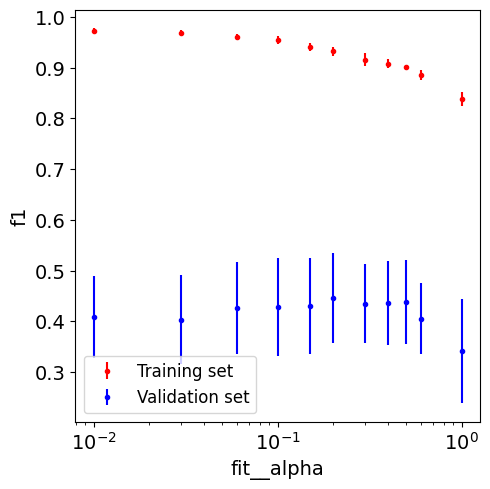

In [50]:
ml.plot_pars_scores(grid)

### Learning curve

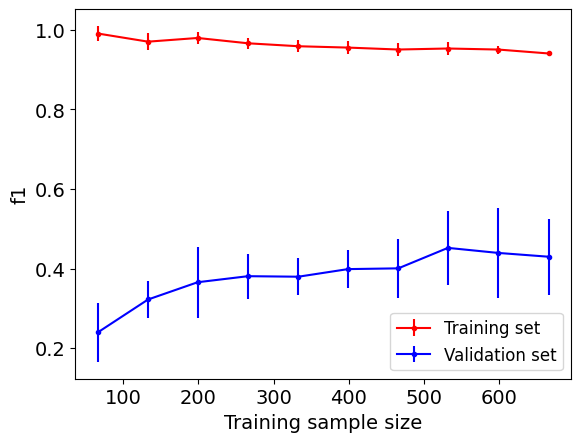

In [51]:
ml.plot_learning_curve(model, X_train, y_train, 'f1')

### Teste na amostra de teste

In [52]:
dump = model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
for metric in ['accuracy', 'f1', 'precision', 'recall']:
    mfunc = get_scorer(metric)._score_func
    print(metric + ': {:.4f}'.format(mfunc(y_test, y_test_pred)))

accuracy: 0.7746
f1: 0.5200
precision: 0.5909
recall: 0.4643


Resultado obtido com os dados não criptografados (train-test split é diferente):|

    accuracy: 0.7982
    f1: 0.5306
    precision: 0.5652
    recall: 0.5000

### Treinando a produção e salvando o modelo

In [53]:
# Registro da performance no teste:
dump = model.fit(X_train, y_train)
y_test_pred  = model.predict(X_test)
y_train_pred = model.predict(X_train) 
final_score = f1_score(y_test, y_test_pred)
train_score = f1_score(y_train, y_train_pred)
print('Test score: {:.4f}'.format(final_score))
print('Train score: {:.4f}'.format(train_score))

Test score: 0.5200
Train score: 0.9325


In [54]:
# Treinando modelo no conjunto completo (de produção):
X_full, y_full = ml.Xy_split(annotated_df, 'not_the_target')
prod_model = clone(model)
dump = prod_model.fit(X_full, y_full)

In [55]:
# Salvando o modelo:
#ml.save_model('../../modelos/nb_wrong_target_classifier_v02/', model, prod_model, train_df, test_df, 'f1', train_score, final_score, package_list=['scikit-learn', 'numpy', 'pandas', 'scipy'])

### Testando modelo salvo

In [77]:
import joblib
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [58]:
# Carrega modelo:
test_model = joblib.load('../../modelos/nb_wrong_target_classifier_v02/tested_model.joblib')
prod_model = joblib.load('../../modelos/nb_wrong_target_classifier_v02/production_model.joblib')

In [68]:
# Carrega os dados utilizados:
train_df = pd.read_csv('../../modelos/nb_wrong_target_classifier_v02/train_data_encrypted.csv')
X_train, y_train  = ml.Xy_split(train_df, 'not_the_target')
test_df  = pd.read_csv('../../modelos/nb_wrong_target_classifier_v02/test_data_encrypted.csv')
X_test, y_test  = ml.Xy_split(test_df, 'not_the_target')

In [69]:
# Resultados:
y_test_pred  = test_model.predict(X_test)
y_train_pred = test_model.predict(X_train) 
print('Test score: {:.4f}'.format(f1_score(y_test, y_test_pred)))
print('Train score: {:.4f}'.format(f1_score(y_train, y_train_pred)))

Test score: 0.5306
Train score: 0.9408


In [70]:
confusion_matrix(y_test, y_test_pred)

array([[156,  20],
       [ 26,  26]])

In [71]:
# Acertou que era pra outra pessoa:
xd.print_string_series(X_test.loc[(y_test_pred == 1) & (y_test == 1), 'text'])

26: @BolsonaroSP Ele é um bosta drogado
27: @IvanValente Tem que ser maluca essa mulher.
32: @verdouglasgomes Imbecil retardada.
Coitada ...
36: @carlosjordy Mas que puta rampeira! She's a cum dumpster!
38: @carteiroreaca Poderia ser varíola das pirocas.
39: @CamargoDireita Bando de esquerdista canalha 😡😡😡😡
44: @carteiroreaca Varíola dos veados. Kkkk
49: @carteiroreaca Varíola do Chupa-cu
51: @CoronelTadeu Palhaçada 
Tinha que esta preso
53: @carteiroreaca Varíola das gazelas!🤣🤣🤣
63: @CarolDeToni Safados terroristas
90: @rsallesmma Atriz de merda
110: @reportersalles Muito dinheiro gasto com carniça ladrã*.
118: @BiologoHenrique Isso é um absurdo!!! Todos temos direito a uma aposentadoria, se alcançarmos a idade.
124: @AbrahamWeint Ele é misógino, fascista, racista, classista, homofóbico, genocida…
Nada disso é mentira
129: @FernandaLoubac2 E assim, os companheiros criminosos dele aqui fora, vão se sentir livres para fazer o que quiserem. Pois se forem presos, sairão.
A justiça dando a

In [72]:
# Acertou que era direto:
xd.print_string_series(X_test.loc[(y_test_pred == 0) & (y_test == 0), 'text'].sample(10))

168: @carteiroreaca @romaocostaadv que o nosso Deus eterno   põe as suas mãos 🙏 sobre o seu filho  e restabeleça a saúde amém
121: @brunosouzasc Então não mentiram pra mim
55: @GuilhermeBoulos Que bosta, vocês denovo para encher o saco ?
84: @GuilhermeBoulos Vai sonhando seu vagabundo 🤣🤣🤣🤣
197: @tuliogadelha #BolsonaroNoPrimeiroTurno 
#MulheresComBolsonaro https://t.co/sEutW0pn9M
151: @AndreJanonesAdv Só porque vc nao grito imbrochavel 😐
28: @CarolDeToni @jairbolsonaro Uma mulher defender um vagabundo machista, Misógino, que menospreza mulheres, é muita falta de amor próprio, tbm acha que nasceu de uma fraquejada, que se for bonita merece ser estuprada, que deve ganhar menos pq engravida..com Lula as mulheres tiveram ganhos..
181: @erlan_bastos Você é podre hein!
193: @nikolas_dm @AdrillesRJorge Vai ter somente os votos da família
2: @ThiagoResiste @LulaOficial @verdadenarede Estou com Lula.


In [73]:
# Falso p/ outra pessoa:
xd.print_string_series(X_test.loc[(y_test_pred == 1) & (y_test == 0), 'text'])

11: @IvanValente Esquerda nunca mais
47: @ThiagoResiste Esquerdista é muito vagabundo mesmo
57: @H1SaiaDaMatrix Kkkkkkkkkkkk ficou pica po
81: @andrefernm Tchutchuca safada!
98: @DelegadoZucco @Direita_Network @jairbolsonaro Mitoooooooooooooooooooooooo
107: Assim como o Brasil não aguenta mais Bolsonaro, Bagé não aguenta mais a família Lara. 
É por entender que precisamos fortalecer a oposição ao bolsonarismo em Bagé que declaro meu apoio ao @DepMainardi, 13555, como deputado estadual!
114: @WilliamJacob @AndreMarinho Tem o link?
115: @samanthacavalca @FariaGiuliana Sucesso!
123: @gleisi Vagabunda corruPTa sem moral
130: @augustodeAB @RenanSantosMBL Estragou o velório
134: @marcia_lucena quero em CG https://t.co/Cy4RZJtWbK
141: @carlossampaio_ Lula está certo. Temos que fazer amizade com o inimigo, só assim livramos deles.
169: @carmelonetobr 22 🇧🇷🇧🇷🇧🇷 🙏🙏 Bolsonaro 🇧🇷🙏🙏🙏
173: @carteiroreaca 🙏🏼🙏🏼🙏🏼
183: @gleisi DISSOLUÇÃO DO SUPREMO 
VINCULADO COMO "ORGÃO AUXILIAR DO CONGRESSO" COM ELEI

In [74]:
# Achou que era p/ o candidato e não era:
xd.print_string_series(X_test.loc[(y_test_pred == 0) & (y_test == 1), 'text'])

7: @BolsonaroSP @profpaulamarisa @JoseMedeirosMT @Eugenia_Assis @MLauraAssis @laderechadiario @giovannilarosa0 @segregustavo Não acreditei e tive que ir lá chegar.

É verdadeiro esse bilhete!

Vai ser burro assim lá na esquerda!

Agência de cherecagem passando vergonha!

Troquem o nome de AosFatos para AosBaralhos para não falar outra coisa.
61: @AbrahamWeint Tinha q levar muita porr@d@ na cara esse vagabundagem!
89: @carteiroreaca Esse lixo desse comuna vai queimar no inferno!!!!
103: @Jouberth19 @antoniotabet “O PT é partido de vagabundo ”.😂😂😂😂Vamos subir a tag.
105: @AbrahamWeint Está proibido dizer que bolzonaro é a TCHUCHUCA DO CENTRÃO
116: @dep_padrejoao Roubalheira
119: @GTavaresPCB Eu tô aqui morrendo de rir do liberal que não conhece o básico do marginalismo. O cara tem que ser muito burro para cair nessa….
122: @deregomesrio Era pra ser na Harmonia, mas quando chove, precisam enfiar em algum canto. Bem, na Estudantina não dá mais. Só se travar um teto de público e parar de en

### Predizendo a probabilidade

In [75]:
X_test['target_prob'] = test_model.predict_proba(X_test)[:, 0]
X_test['final_prob'] = X_test['hate_score'] * X_test['target_prob']
X_test['variacao'] = X_test['final_prob'] - X_test['hate_score']

In [76]:
X_test[['text', 'hate_score', 'target_prob', 'final_prob', 'variacao']].sort_values('variacao').head(30).style.set_properties(subset=['text'], **{'width': '1500px'})

,text,hate_score,target_prob,final_prob,variacao
38,@carteiroreaca Poderia ser varíola das pirocas.,0.838341,0.002856,0.002394,-0.835947
123,@gleisi Vagabunda corruPTa sem moral,0.993122,0.182687,0.181430,-0.811691
53,@carteiroreaca Varíola das gazelas!🤣🤣🤣,0.760350,0.001211,0.000921,-0.759429
39,@CamargoDireita Bando de esquerdista canalha 😡😡😡😡,0.801967,0.114093,0.091499,-0.710468
36,@carlosjordy Mas que puta rampeira! She's a cum dumpster!,0.949361,0.258162,0.245089,-0.704272
44,@carteiroreaca Varíola dos veados. Kkkk,0.693937,0.000017,0.000011,-0.693926
32,@verdouglasgomes Imbecil retardada. Coitada ...,0.721338,0.103738,0.074830,-0.646507
166,@rsallesmma Eu processava essa doidinha que chamou de fela da puts,0.909877,0.291621,0.265339,-0.644538
49,@carteiroreaca Varíola do Chupa-cu,0.840771,0.245559,0.206459,-0.634312
63,@CarolDeToni Safados terroristas,0.941481,0.335047,0.315440,-0.626040
